In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill # for loading and saving a trained model
from nowcast_lstm.LSTM import LSTM

# Basic model usage
**\*note*** the model assumes stationary, seasonally adjusted series. So make sure required transformations are already performed by this point.
<br><br>
Data should a dataframe with rows of the highest granularity of data. For example, predicting a yearly variable with monthly, quarterly, and yearly features should have a monthly dataframe. Quarterly variables should be represented as a single value during the period, with missings (`np.nan`) in between. E.g. Q1 data would be `np.nan` for January, `np.nan` for February, the value for March, etc. Yearly data would be `np.nan` for January - November, and the value for December.

In [2]:
# data read
data = pd.read_csv("data.csv")
data = data.loc[:, ["x_jp", "x_world", "x_de", "x_uk", "ipi_cn"]] # random subset of columns for simplicity, do not include the date column

In [3]:
# training and test datasets
training = data.loc[:len(data)*0.8,:]
test = data.loc[len(data)*0.8:,:]

In [4]:
# instantiating a model with 10 networks based on the previous 12 months with 50 train episodes. Defaults to mean-filling missing values. See documentation for more information on hyper-parameters.
model = LSTM(data=training, target_variable="x_world", n_timesteps=12, n_models=10, train_episodes=50)

In [5]:
# train the model, quiet=True to suppress printing of training loss
model.train(quiet=True)

Training model 1


/home/danhopp/miniconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7
Training model 8
Training model 9
Training model 10


In [6]:
# getting predictions on the train set. To get predictions on periods that don't have an actual value, set drop_missing_ys = False. This will preserve all observations, even if there is no actual, and thus enable prediction on periods in the future.
train_preds = model.predict(model.X)

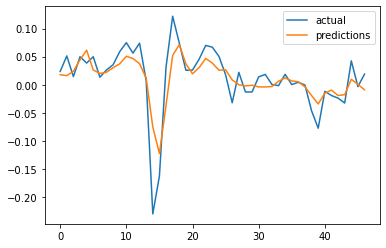

In [7]:
# performance on the train set
plt.plot(model.y, label="actual") 
plt.plot(train_preds, label="predictions")
plt.legend();

In [8]:
# creating a new LSTM object from the test set. This is to generate a dataset of the proper format to be accepted by the model, so needs the same target variable and n_timesteps as the model was trained on. Pass `fill_na_other_df` to fill missings with mean of training data rather than test data to improve performance.
new_data = LSTM(data=test, target_variable=model.target_variable, n_timesteps=model.n_timesteps, fill_na_other_df=model.data) # equivalent to `fill_na_other_df = training`

# getting predictions on the test set
test_preds = model.predict(new_data.X)

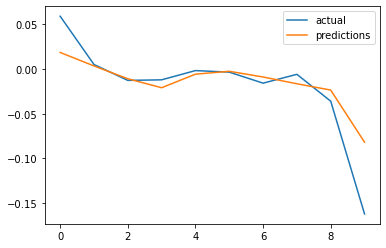

In [9]:
# performance on the test set
plt.plot(new_data.y, label="actual")
plt.plot(test_preds, label="predictions")
plt.legend();

In [10]:
# saving a trained model
dill.dump(model, open("trained_model.pkl", mode='wb'))

In [11]:
# loading a trained model
trained_model = dill.load(open("trained_model.pkl", "rb", -1))

# Realistic model evaluation scenario
The test set above assumes full data for each test observation, this is rarely the case with economic data. The process below outlines how to check the performance of the model on different data vintages, i.e. how the data would have looked at various points in time leading up to the prediction period.

In [10]:
# data read
data = pd.read_csv("data.csv")
data = data.loc[:, ["x_jp", "x_world", "x_de", "x_uk", "ipi_cn"]] # random subset of columns for simplicity

### n_timesteps
This is the number of leading periods that the model will be estimated on, see documentation for more information. Relevant for test/train sets because to have every target observation in the test set, we also need the trailing `n_timesteps-1` rows of data. For example say we have `n_timesteps=12`, i.e. a model based on 1 year history of monthly data, if our train set stops at 2019-12-01, and our test set begins at 2020-01-01, to be able to predict a value for 2020-01-01, we need data back to 2019-02-01 to have a full dataset for that observation.
<br><br>
This `n_timesteps-1` provision can be left out, however. Then the first test observation will be `n_timesteps-1` ahead of the first row of our test data. E.g. in the case mentioned before, 2020-12-01 will be the first test observation we can predict on, as it is the first observation where a full 12 month history exists in our test data starting on 2020-01-01.

In [11]:
# training and test datasets
n_timesteps = 12
n_models = 10
train_row_end = round(len(data)*0.8) # training on 80% of the data
test_row_begin = train_row_end - (n_timesteps - 1)

train = data.loc[:train_row_end,:]
test = data.loc[test_row_begin:,:]

In [12]:
# target column
target = "x_world"

### pub_lags
This is a vector of dimensions 1 x n_features. I.e. the number of independent variables in the model, this means NOT including the target variable. So for a model with a 200 x 10 dataframe, with 200 observations and 10 columns, the lags vector should have 9 entries, one for each variable less the target column.
<br><br>
Its function is to provide the publication lag/schedule for each series to be able to generate data vintages via the `gen_ragged_X` function. The contents should therefore be the number of periods of lag each series experienced when published. For example, if there are three independent variables in a monthly model, GDP, exports, and the business confidence index, and they are published with a 3, 2, and 1 month lag, respectively, the lag vector should read `[3,2,1]`, or in whatever order the columns are in the original dataframe. If the target period is June, values with a lag of 2 are available until April. A value of 1 means values are available to May. A lag value of 0 means that if we are in June, June values are available. 
<br><br>
The units of the lag is the units of the original dataframe, i.e. the highest granularity of data. The monthly example above should then be extrapolated for the case of e.g. daily or quarterly data.

In [13]:
# example publication lags. Means x_jp comes out 1 month later, x_de 0 months later, x_uk 2 months later, ipi_cn 3 months later
pub_lags = [1, 0, 2, 3]

In [14]:
# model instantiation and training
model = LSTM(train, target, n_timesteps=n_timesteps, n_models=n_models)
model.train(quiet=True)

Training model 1
Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7
Training model 8
Training model 9
Training model 10


### model assessment on vintages
The first testing example in this notebook made predictions on full datasets, i.e as if the lags for all variables was 0. This is an unrealistic scenario, so a better evaluation of a nowcasting model's performance is testing it on incomplete datasets that reflect real data publication conditions. The code below therefore uses the `pub_lags` vector and the `gen_ragged_X` function to create vintage datasets to test on. The below example will find performance of the model as if predictions were made 1 and 2 months before the target period, in the target period, and 1 and 2 months after the target period. The appropriate prediction periods should be chosen as relevant for the use case of the nowcast. Testing continues after the target period because of publication lags. If we are nowcasting Q2 numbers and are in June, that does not mean that we have full data for June. Some figures from Q2 months may not come out until July or August, therefore the testing on vintages past the target period.

In [15]:
# putting test data into the format required to make predictions. Passing the training data to the fill_na_other_df parameter bases missings on the mean of the training data, rather than the test data
test_data = LSTM(test, model.target_variable, n_timesteps=model.n_timesteps, fill_na_other_df=model.data)

### gen_ragged_X function
This function creates data vintages using a publication schedule, `pub_lags` vector, explained above. The second parameter, `lag`, is the simulated period offset. It can be interpreted as the last period with full data relative to the target period. If we are nowcasting Q2, i.e. June, a lag of 0 simulates being in June. I.e. June is the last month with full data (for variables with lag 0). A lag of -1 simulates being in May, where May is the last full month. A lag of 1 simulates being in July, where variable with a lag of 1 now have June data as well. How many missings will be generated for a series can be calculated with `-1*(lag - variable_pub_lag)`. E.g. we set the lagged period to -2 months back, and the variable has a 1 month publication lag, `-1*(-2-1)=3`, so the last three months will be set to missing.
<br><br>
Generally we should expect to see evaluation metrics get better the further ahead in time we move, as more data is available.

In [16]:
# performance on a single vintage, 1 month back of target period
lag = -2 # i.e. we are 2 months back of target period, 2 months ago is the last completed period for variables with lag 0
prediction_data = test_data.gen_ragged_X(pub_lags, lag)
preds = model.predict(prediction_data)
    
# different evaluation metrics, test_data.y is actuals
RMSE = np.sqrt(np.mean((test_data.y - preds)**2))
MAE = np.mean(np.abs(test_data.y - preds))

print(f"RMSE: {np.round(RMSE, 4)}")
print(f"MAE: {np.round(MAE, 4)}")

RMSE: 0.0254
MAE: 0.0217


In [17]:
# adding back dates to the test set for easier interpretation in plots
dates = pd.read_csv("data.csv", parse_dates=["date"]).loc[:,["date", target]] # dataframe of dates + target variable
dates = dates.loc[(test_row_begin + (n_timesteps-1)):, :].reset_index(drop=True) # get testing subset, undoing provision of n_timesteps-1 rows, because dates in this range don't fall in the test observations due to history required for n_timesteps
dates = dates.loc[~pd.isna(dates[target]),:].reset_index(drop=True) # only keep dates where there was a test observation

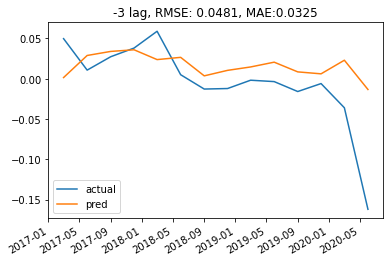

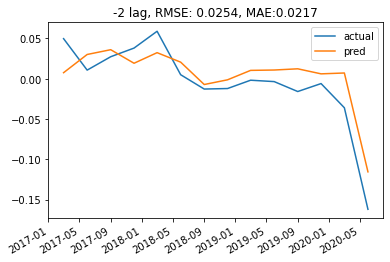

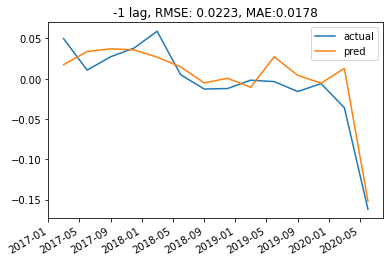

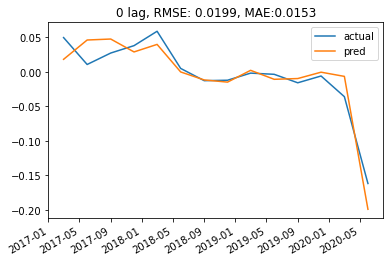

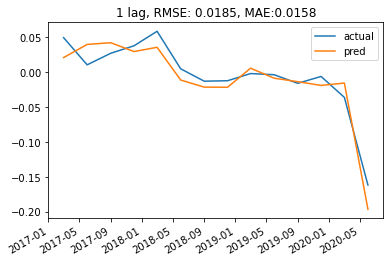

In [18]:
# visualization of performance over time, to see how performance develops
for lag in [-3, -2, -1, 0, 1]: # 2 month back, 1 month back, month-of, 1 month ahead, 2 months ahead vintages
    preds = model.predict(test_data.gen_ragged_X(pub_lags, lag))
    
    # different evaluation metrics, test_data.y is actuals
    RMSE = np.sqrt(np.mean((test_data.y - preds)**2))
    MAE = np.mean(np.abs(test_data.y - preds))
    
    # plotting results
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    
    ax.plot(dates.date, test_data.y, label="actual")
    ax.plot(dates.date, preds, label=f"pred")
    plt.title(f"{lag} lag, RMSE: {np.round(RMSE,4)}, MAE:{np.round(MAE,4)}")
    plt.legend()
    plt.show()

# Different filling NA options
The default behavior of the model is to fill missings/NAs with the mean of the series. There are however other approaches, this section will outline different implementations available in the library.

### 2 types of missing values:
- _within-series missings_: E.g. quarterly data that is forced to be monthly will have NAs in between observations, or if a series just has some missing values within it. Fill these with the `fill_na_func` parameter in `LSTM` instantiation. The function must take a series and return a scalar, e.g. `np.nanmean`, `np.nanmedian`, etc.

- _ragged edges_: I.e. observations that haven't come out yet because of publication lag. These happen exclusively at the end of the series. Fill these with the `fill_ragged_edges_func` parameter in `LSTM` instantiation. The function must take a series and return a scalar, e.g. `np.nanmean`, `np.nanmedian`, or enter `"ARMA"` to use ARMA estimation. Don't pass anything to use the same function as passed to `fill_na_func`.

In [19]:
# data setup
data = pd.read_csv("data.csv")
data = data.loc[:, ["x_jp", "x_world", "x_de", "x_uk", "ipi_cn"]] # random subset of columns for simplicity

# training and test datasets
n_timesteps = 12
n_models = 10
train_row_end = round(len(data)*0.8) # training on 80% of the data
test_row_begin = train_row_end - (n_timesteps - 1)

train = data.loc[:train_row_end,:]
test = data.loc[test_row_begin:,:]

In [20]:
# looking at the end of the test dataset, we can see some ragged edges
test.tail(10)

,x_jp,x_world,x_de,x_uk,ipi_cn
217,0.027627,NaN,0.004619,-0.031730,NaN
218,-0.014492,-0.036013,-0.099137,-0.175902,-0.011
219,-0.113030,NaN,-0.266919,-0.182739,0.039
220,-0.041397,NaN,0.104712,0.026440,0.044
221,0.009955,-0.161963,0.169252,0.147717,0.048
222,0.069343,NaN,0.069704,0.063219,NaN
223,0.057047,NaN,0.061412,0.111469,NaN
224,0.038700,NaN,0.026040,-0.050565,NaN
225,0.029190,NaN,NaN,NaN,NaN
226,NaN,NaN,NaN,NaN,NaN


In [21]:
# we can fill these using the mean of the series (*note* `x_world` has been moved to the end and has not had NAs filled as it is the target variable)
LSTM(test, "x_world", n_timesteps=12, fill_na_func=np.nanmean).dataset["na_filled_dataset"][-10:,:] # pass fill_na_func=np.nanmedian to use the median

array([[ 0.0276267 ,  0.00461852, -0.03173023,  0.05844186,         nan],
       [-0.01449206, -0.09913715, -0.17590209, -0.011     , -0.03601337],
       [-0.11302959, -0.26691904, -0.18273938,  0.039     ,         nan],
       [-0.04139658,  0.10471231,  0.02643966,  0.044     ,         nan],
       [ 0.00995518,  0.16925243,  0.1477169 ,  0.048     , -0.1619629 ],
       [ 0.06934314,  0.06970384,  0.06321936,  0.05844186,         nan],
       [ 0.05704716,  0.06141213,  0.11146881,  0.05844186,         nan],
       [ 0.03869957,  0.02603982, -0.05056482,  0.05844186,         nan],
       [ 0.0291901 ,  0.0032492 ,  0.0011618 ,  0.05844186,         nan],
       [ 0.00238983,  0.0032492 ,  0.0011618 ,  0.05844186,         nan]])

In [22]:
# this is fine for a training set, but for a test set we usually want to use the training set to calculate the means, medians, etc., as this is what the model was trained on. In this case pass the training data to `fill_na_other_df` during instantiation, we will see that the filled NA values are slightly different
model = LSTM(train, "x_world", n_timesteps=12, fill_na_func=np.nanmean)
LSTM(test, model.target_variable, model.n_timesteps, fill_na_func=model.fill_na_func, fill_na_other_df=model.data).dataset["na_filled_dataset"][-10:,:]

array([[ 0.0276267 ,  0.00461852, -0.03173023,  0.12761111,         nan],
       [-0.01449206, -0.09913715, -0.17590209, -0.011     , -0.03601337],
       [-0.11302959, -0.26691904, -0.18273938,  0.039     ,         nan],
       [-0.04139658,  0.10471231,  0.02643966,  0.044     ,         nan],
       [ 0.00995518,  0.16925243,  0.1477169 ,  0.048     , -0.1619629 ],
       [ 0.06934314,  0.06970384,  0.06321936,  0.12761111,         nan],
       [ 0.05704716,  0.06141213,  0.11146881,  0.12761111,         nan],
       [ 0.03869957,  0.02603982, -0.05056482,  0.12761111,         nan],
       [ 0.0291901 ,  0.00555967,  0.00339311,  0.12761111,         nan],
       [ 0.00406629,  0.00555967,  0.00339311,  0.12761111,         nan]])

Ragged edges can also be filled by ARMA estimation, in the below example ARMA parameters are estimated on the `fill_na_other_df` (i.e. the training data) using `pmdarima.arima.auto_arima`. Leaving the parameter out would estimate the model on the test data itself. The model is then fit on the test data:

In [23]:
# ragged edges can also be filled by ARMA estimation, in the below example ARMA parameters are estimated on the `fill_na_other_df` (i.e. the training data) using `pmdarima.arima.auto_arima`
# leaving the parameter out would estimate the model on the test data itself. The ARMA model is then fit on the test data
LSTM(test, model.target_variable, model.n_timesteps, fill_na_func=model.fill_na_func, fill_na_other_df=model.data, fill_ragged_edges_func="ARMA").dataset["na_filled_dataset"][-10:,:]

array([[ 0.0276267 ,  0.00461852, -0.03173023,  0.12761111,         nan],
       [-0.01449206, -0.09913715, -0.17590209, -0.011     , -0.03601337],
       [-0.11302959, -0.26691904, -0.18273938,  0.039     ,         nan],
       [-0.04139658,  0.10471231,  0.02643966,  0.044     ,         nan],
       [ 0.00995518,  0.16925243,  0.1477169 ,  0.048     , -0.1619629 ],
       [ 0.06934314,  0.06970384,  0.06321936,  0.05004264,         nan],
       [ 0.05704716,  0.06141213,  0.11146881,  0.05203623,         nan],
       [ 0.03869957,  0.02603982, -0.05056482,  0.0536278 ,         nan],
       [ 0.0291901 ,  0.0032492 , -0.00655767,  0.05458992,         nan],
       [ 0.00662341,  0.0032492 , -0.00085045,  0.05540955,         nan]])

In [24]:
# for a test set, however, the ARMA model should be fit on the full history of the series up to the target period (including training data + test data)
# this requires the passing of an additional parameter, `arma_full_df`. This is the dataframe that contains the full history of the series, before the split into train and test
model = LSTM(train, "x_world", n_timesteps=12, fill_na_func=np.nanmean)
LSTM(test, model.target_variable, model.n_timesteps, fill_na_func=model.fill_na_func, fill_na_other_df=model.data, fill_ragged_edges_func="ARMA", arma_full_df=data).dataset["na_filled_dataset"][-10:,:]

array([[ 0.0276267 ,  0.00461852, -0.03173023,  0.12761111,         nan],
       [-0.01449206, -0.09913715, -0.17590209, -0.011     , -0.03601337],
       [-0.11302959, -0.26691904, -0.18273938,  0.039     ,         nan],
       [-0.04139658,  0.10471231,  0.02643966,  0.044     ,         nan],
       [ 0.00995518,  0.16925243,  0.1477169 ,  0.048     , -0.1619629 ],
       [ 0.06934314,  0.06970384,  0.06321936,  0.04820525,         nan],
       [ 0.05704716,  0.06141213,  0.11146881,  0.04972515,         nan],
       [ 0.03869957,  0.02603982, -0.05056482,  0.05152291,         nan],
       [ 0.0291901 ,  0.00524286,  0.00592706,  0.05289985,         nan],
       [ 0.01227168,  0.00524286, -0.00069475,  0.05428497,         nan]])

These parameters also have implications for the `gen_ragged_X` function, which artifically creates ragged edges based on publication lags. The ragged edge filling method specified in instantiation will also be used for filling these artificial NAs

In [37]:
model = LSTM(train, "x_world", n_timesteps=12, fill_na_func=np.nanmean)
test_LSTM = LSTM(test, model.target_variable, model.n_timesteps, fill_na_func=model.fill_na_func, fill_na_other_df=model.data, fill_ragged_edges_func="ARMA", arma_full_df=data)

In [38]:
# original data of the first observation of the test set
test_LSTM.X[0, :, :]

array([[ 0.02595659,  0.01978812,  0.09574915,  0.06      ],
       [ 0.00303562, -0.01943818, -0.05274861,  0.06      ],
       [ 0.04958814, -0.01121171, -0.00124811,  0.062     ],
       [-0.00859215, -0.0257523 , -0.04548142,  0.06      ],
       [ 0.01792986,  0.04862021, -0.00446397,  0.063     ],
       [ 0.01742758, -0.00685483, -0.00873935,  0.061     ],
       [-0.0175591 , -0.01297319, -0.00330035,  0.061     ],
       [-0.02398438, -0.00562538,  0.02279321,  0.062     ],
       [-0.03532639, -0.03786355,  0.0340238 ,  0.06      ],
       [ 0.01945834,  0.0292625 , -0.01142528,  0.12761111],
       [ 0.07950673,  0.01772   ,  0.0246962 ,  0.12761111],
       [-0.02019425,  0.01724376, -0.02677482,  0.076     ]])

In [39]:
# mean filled artificial edges
test_LSTM = LSTM(test, model.target_variable, model.n_timesteps, fill_na_func=model.fill_na_func, fill_na_other_df=model.data)
test_LSTM.gen_ragged_X(pub_lags=[1,0,2,3], lag=-2)[0,:,:]

array([[ 0.02595659,  0.01978812,  0.09574915,  0.06      ],
       [ 0.00303562, -0.01943818, -0.05274861,  0.06      ],
       [ 0.04958814, -0.01121171, -0.00124811,  0.062     ],
       [-0.00859215, -0.0257523 , -0.04548142,  0.06      ],
       [ 0.01792986,  0.04862021, -0.00446397,  0.063     ],
       [ 0.01742758, -0.00685483, -0.00873935,  0.061     ],
       [-0.0175591 , -0.01297319, -0.00330035,  0.061     ],
       [-0.02398438, -0.00562538,  0.02279321,  0.12761111],
       [-0.03532639, -0.03786355,  0.00339311,  0.12761111],
       [ 0.00406629,  0.0292625 ,  0.00339311,  0.12761111],
       [ 0.00406629,  0.00555967,  0.00339311,  0.12761111],
       [ 0.00406629,  0.00555967,  0.00339311,  0.12761111]])

In [40]:
# ARMA filled artificial edges
test_LSTM = LSTM(test, model.target_variable, model.n_timesteps, fill_na_func=model.fill_na_func, fill_na_other_df=model.data, fill_ragged_edges_func="ARMA", arma_full_df=data)
test_LSTM.gen_ragged_X(pub_lags=[1,0,2,3], lag=-1)[0,:,:]

array([[ 0.02595659,  0.01978812,  0.09574915,  0.06      ],
       [ 0.00303562, -0.01943818, -0.05274861,  0.06      ],
       [ 0.04958814, -0.01121171, -0.00124811,  0.062     ],
       [-0.00859215, -0.0257523 , -0.04548142,  0.06      ],
       [ 0.01792986,  0.04862021, -0.00446397,  0.063     ],
       [ 0.01742758, -0.00685483, -0.00873935,  0.061     ],
       [-0.0175591 , -0.01297319, -0.00330035,  0.061     ],
       [-0.02398438, -0.00562538,  0.02279321,  0.062     ],
       [-0.03532639, -0.03786355,  0.0340238 ,  0.0652841 ],
       [ 0.01945834,  0.0292625 , -0.00738939,  0.06765835],
       [-0.00487862,  0.01772   ,  0.00160485,  0.0697329 ],
       [ 0.00363019,  0.00549511, -0.00034855,  0.07187835]])

# NA filling methods for a full dataset
Most of these filling NA provisions are only relevant for a testing/model selection phase. In production, once hyper-parameters are tuned, it is feasible to simply feed the complete dataset with actual ragged edges and retrain the model every time for inference. That would look as follows: 

In [44]:
# data setup
data = pd.read_csv("data.csv")
data = data.loc[:, ["x_jp", "x_world", "x_de", "x_uk", "ipi_cn"]] # random subset of columns for simplicity

# training and test datasets
n_timesteps = 12
n_models = 10

model = LSTM(data, "x_world", n_timesteps=12, fill_ragged_edges_func="ARMA") # for ARMA filling based on history of length n_timesteps (i.e. recent past)
model = LSTM(data, "x_world", n_timesteps=12, fill_ragged_edges_func="ARMA", arma_full_df=data) # for ARMA filling based on full series history
model.train(quiet=True)

Training model 1


In [71]:
# want inference on x_world for Q3 2020
date_info = pd.read_csv("data.csv", parse_dates=["date"])
max_index = date_info.index.max()
desired_index = date_info.loc[date_info.date == "2020-09-01", :].index[0]
index_diff = max_index - desired_index - 1
model.data.tail(10)

,x_jp,x_world,x_de,x_uk,ipi_cn
217,0.027627,NaN,0.004619,-0.031730,NaN
218,-0.014492,-0.036013,-0.099137,-0.175902,-0.011
219,-0.113030,NaN,-0.266919,-0.182739,0.039
220,-0.041397,NaN,0.104712,0.026440,0.044
221,0.009955,-0.161963,0.169252,0.147717,0.048
222,0.069343,NaN,0.069704,0.063219,NaN
223,0.057047,NaN,0.061412,0.111469,NaN
224,0.038700,NaN,0.026040,-0.050565,NaN
225,0.029190,NaN,NaN,NaN,NaN
226,NaN,NaN,NaN,NaN,NaN


In [72]:
inference_data = LSTM(data, "x_world", n_timesteps=12, fill_ragged_edges_func="ARMA", arma_full_df=data, drop_missing_ys=False) # same as the training model, but drop_missing_ys set to false for inference on unpublished values
model.predict(inference_data.X)[-index_diff]

0.11346053